## 1. Load voxel model and preview

In [1]:
from setup.voxel_setup import setup_voxel_scene, NUM_XYZ
import taichi as ti

# debug=True to check boundary access
ti.init(arch=ti.gpu)
scene, floor_height = setup_voxel_scene()
# scene.display()

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda
Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


## 3. Perform light simulation

In [8]:
from common.plot import Plotter
from data.octree import Octree
from data.mlp import MLP
from data.siren import SirenFitter
from simulation.simulator import normalize_by_max, get_irrad_loc_dir, compute_ior_gradient
from scipy import ndimage


%load_ext autoreload
%autoreload 2
# May comment it because the compatibility of this extension is not good
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(7-samplers).npz


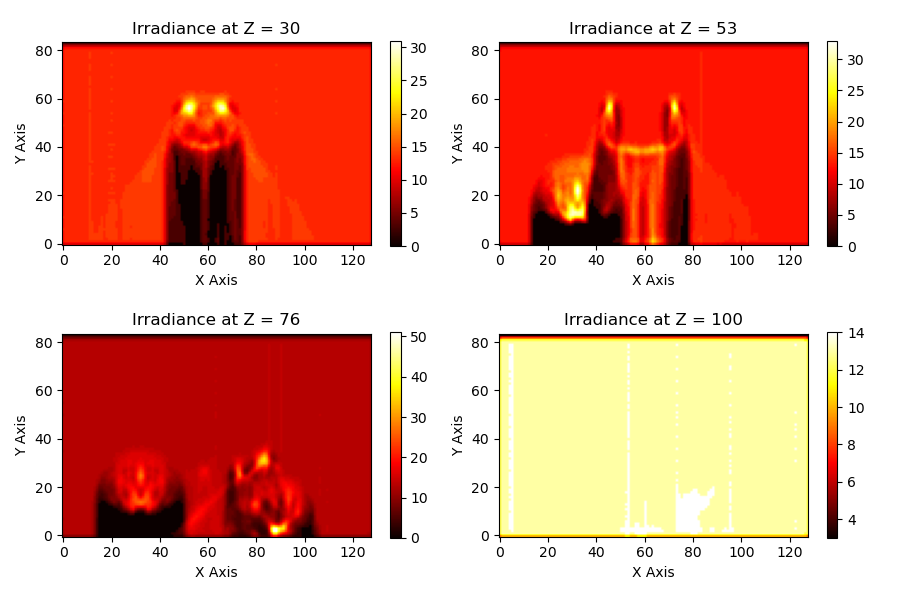

In [3]:
sampler_multiplier = 7
to_load_save = True

plotter = Plotter(sampler_multiplier, floor_height)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)
scene.irradiance, scene.local_diretion = get_irrad_loc_dir(scene, sampler_multiplier, to_load_save=to_load_save, plotter=plotter)

plotter.plot_irradiance_slices(scene.irradiance[:, floor_height:, :], threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
# plotter.plot_wavefront(scene.ior, None, None)
# plotter.plot_gradient(scene.gradient, threshold=0.2)
# plotter.plot_irradiance_grid(scene.irradiance)
# plotter.plot_local_direction_grid_slices(scene.local_diretion[:, floor_height:, :], num_slices=4, z_start=30, z_end=100)

## 4. Fit irradiance using SIREN 

In [12]:
siren_fitter= SirenFitter(scene.irradiance, floor_height, sampler_multiplier,
                     hidden_features=256, hidden_layers=3, omega=24)
siren_fitter.fit(total_epochs=24, batch_size=20000, lr=5e-4)

[ Not found ] SIREN model file "SIREN(Irrad)(7-samplers)(24-epoches)(24 omega).pt" does not exist. Start training the model...
Epoch: 1 	Average Loss: 86.0797 	Learning Rate: [0.0005]
Epoch: 5 	Average Loss: 6.8088 	Learning Rate: [0.0005]
Epoch: 10 	Average Loss: 5.2148 	Learning Rate: [0.0005]
Epoch: 15 	Average Loss: 4.5684 	Learning Rate: [0.0005]
Epoch: 20 	Average Loss: 3.7498 	Learning Rate: [0.0005]
Epoch: 24 	Average Loss: 3.6074 	Learning Rate: [0.0005]


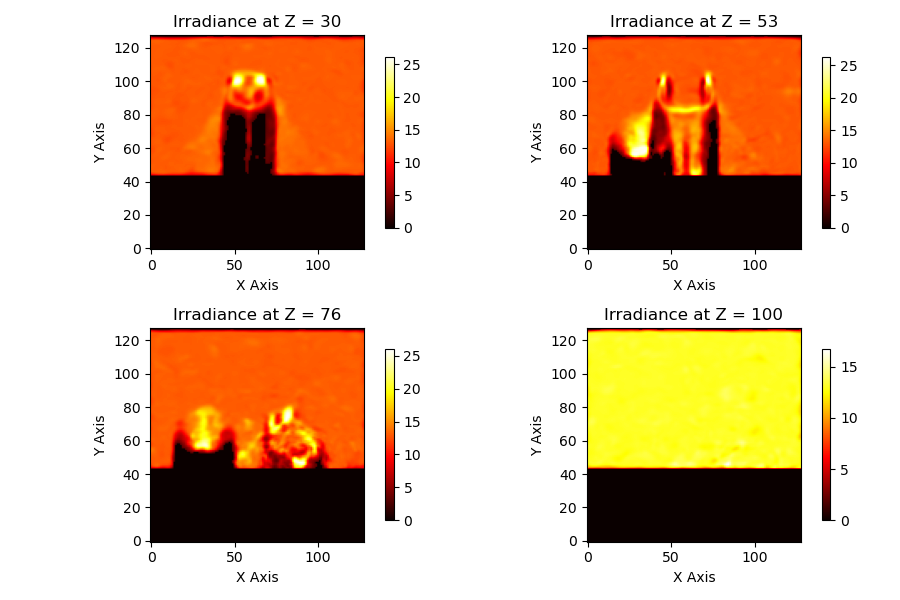

(128, 128, 128)

In [13]:
siren_res = siren_fitter.infer()
plotter.plot_irradiance_slices(siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)
siren_res.shape

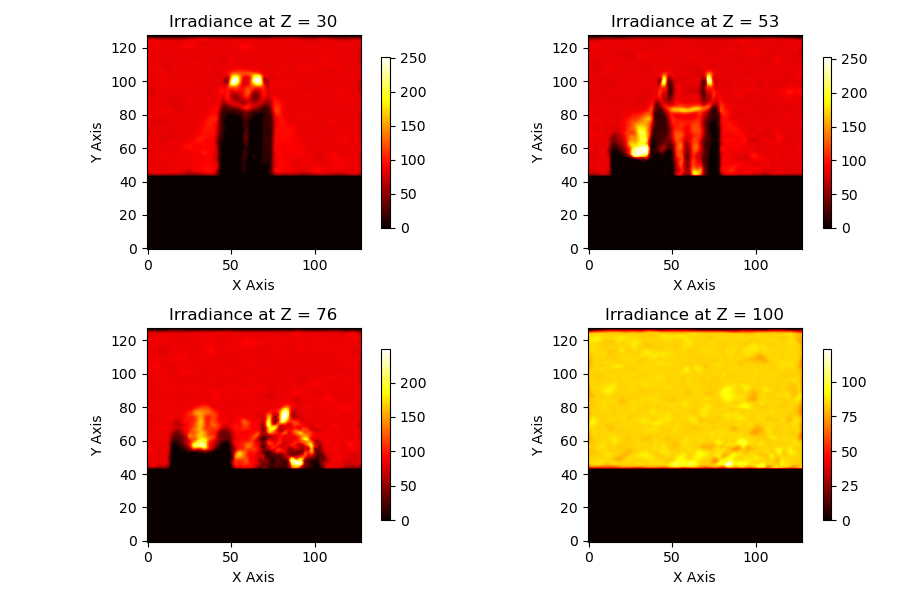

In [15]:
normalized_siren_res = normalize_by_max(siren_res)
gamma = 0.6
corrected_siren_res = ((normalized_siren_res / 255.0) ** (1.0 / gamma)) * 255.0
plotter.plot_irradiance_slices(corrected_siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)

## 5. Fit irradiance using MLP

In [16]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier, num_epoches=80)

Inputs shape: (1376256, 3) ; Targets shape: torch.Size([1376256])
[ Not found ] model file "MLP(Irrad)(7-samplers)(80-epoches).pt" does not exist. Start training the model...
Device: cuda
Epoch [5/80], Train Loss: 6.4368, Val Loss: 9.2302
Epoch [10/80], Train Loss: 4.5591, Val Loss: 6.0040
Epoch [15/80], Train Loss: 3.5305, Val Loss: 4.9149
Epoch [20/80], Train Loss: 3.3513, Val Loss: 4.7281
Epoch [25/80], Train Loss: 4.0523, Val Loss: 4.7827
Epoch [30/80], Train Loss: 3.4453, Val Loss: 4.3740
Epoch [35/80], Train Loss: 3.9372, Val Loss: 4.4370
Epoch [40/80], Train Loss: 2.8319, Val Loss: 3.3401
Epoch [45/80], Train Loss: 4.3188, Val Loss: 4.6725
Epoch [50/80], Train Loss: 2.6965, Val Loss: 3.5480
Epoch [55/80], Train Loss: 4.6532, Val Loss: 5.3113
Epoch [60/80], Train Loss: 1.6791, Val Loss: 2.7775
Epoch [65/80], Train Loss: 2.4663, Val Loss: 2.5723
Epoch [70/80], Train Loss: 1.6077, Val Loss: 2.2237
Epoch [75/80], Train Loss: 2.6692, Val Loss: 2.8431
Epoch [80/80], Train Loss: 1.6147

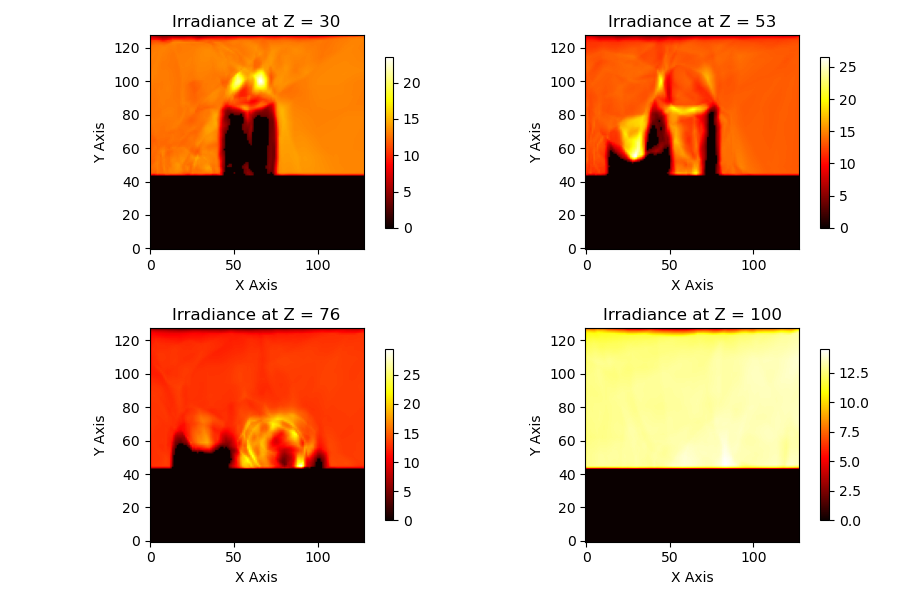

In [17]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

## 6. Store irradiance in octree

Number of nodes: 126537
Octree Memory usage: 7086072 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


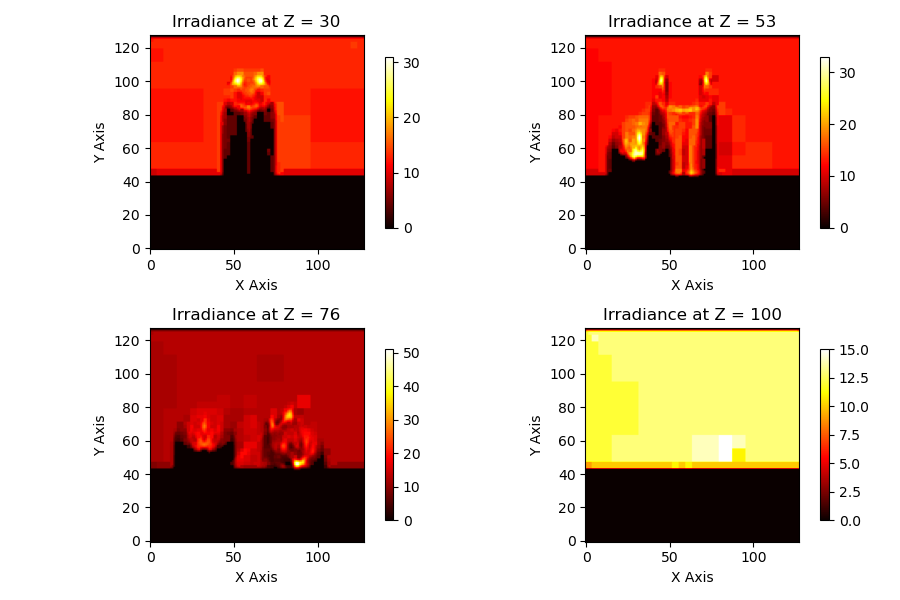

In [9]:
octree = Octree(threshold=4)
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [18]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

1.0

## 6. Ray marching render